In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
# import os

# def remove_images(directory, number_to_remove):
#     images = os.listdir(directory)
#     images = [image for image in images if image.endswith('.jpg') or image.endswith('.jpeg')]  # Filter for specific image formats

#     if number_to_remove > len(images):
#         print("Number of images to remove exceeds the total number of images.")
#         return

#     images_to_remove = images[:number_to_remove]  # Select the first 'number_to_remove' images

#     for image in images_to_remove:
#         os.remove(os.path.join(directory, image))
#         print(f"Removed: {image}")

# # Example usage
# directory_path = '/content/drive/My Drive/research/skin_cancer/train_data/train/benign'
# number_of_images_to_remove = 821

# remove_images(directory_path, number_of_images_to_remove)

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg" or ftype == ".jpeg":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
# import os
# import cv2
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# def Dataset_loader(DIR, RESIZE, sigmaX=10):
#     IMG = []
#     # read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
#     count = 0  # Counter to track rows

#     for IMAGE_NAME in tqdm(os.listdir(DIR)):
#         PATH = os.path.join(DIR, IMAGE_NAME)
#         _, ftype = os.path.splitext(PATH)
#         if ftype == ".jpg" or ftype == ".jpeg":
#             img = cv2.imread(PATH)

#             img = cv2.resize(img, (RESIZE, RESIZE))

#             # Convert the image to grayscale
#             gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#             # Apply Gaussian Blur to smooth the image
#             blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

#             # Apply Thresholding to create a binary image
#             _, thresh_img = cv2.threshold(blurred_img, 100, 255, cv2.THRESH_BINARY)

#             # Expand dimensions to convert single-channel to three channels
#             expanded_img = np.expand_dims(thresh_img, axis=2)
#             expanded_img = np.concatenate([expanded_img] * 3, axis=2)

#             IMG.append(expanded_img)  # Append the processed image

#     return IMG


In [ ]:
benign = np.array(Dataset_loader('/content/drive/MyDrive/research/skin_cancer/train_data/train/benign',224))
malignant = np.array(Dataset_loader('/content/drive/MyDrive/research/skin_cancer/train_data/train/malignant',224))

100%|██████████| 3026/3026 [00:57<00:00, 52.59it/s] 


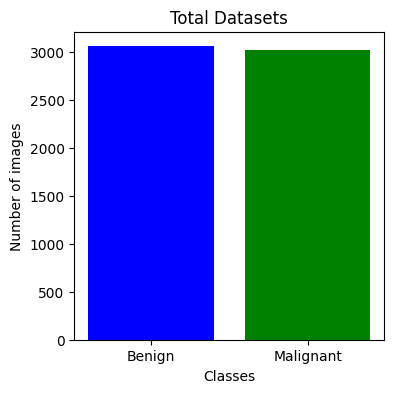

In [ ]:
dataset_lengths = [len(benign), len(malignant)]
datasets = ['Benign', 'Malignant']

# Plot
plt.figure(figsize=(4, 4))
plt.bar(datasets, dataset_lengths, color=['blue', 'green'])
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Total Datasets')
plt.show()

In [ ]:
print(len(benign))
benign.shape

3060


(3060, 224, 224, 3)

In [ ]:
# Create labels
benign_label = np.zeros(len(benign))
malignant_label = np.ones(len(malignant))

In [ ]:
# Merge data
X_train = np.concatenate((benign, malignant), axis = 0)
Y_train = np.concatenate((benign_label, malignant_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

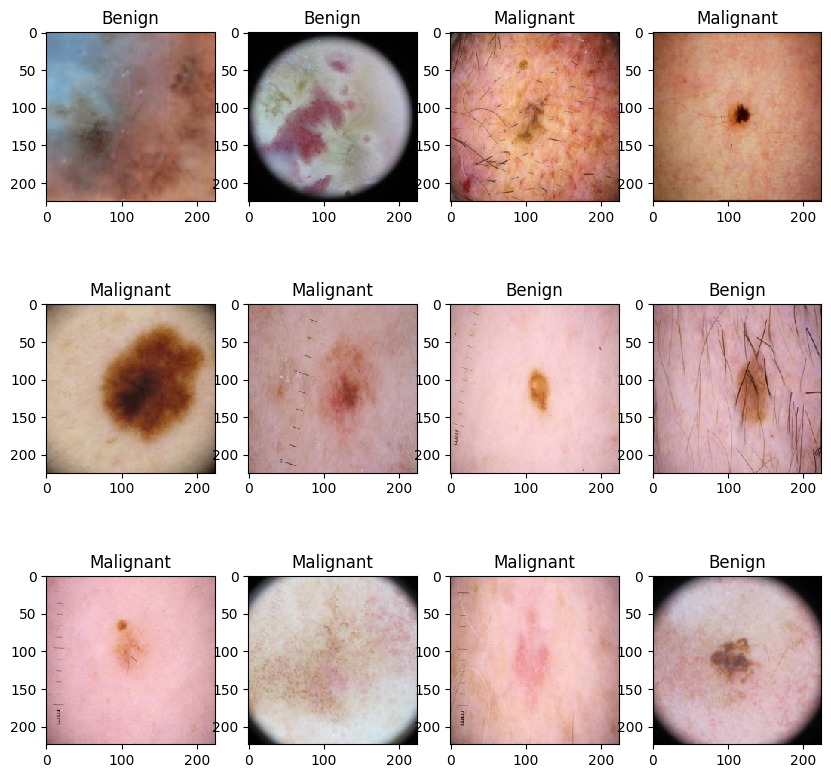

In [ ]:
# # Display first 15 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        # zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

nas   = Xception(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
# resnet      = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
# vgg      = InceptionResNetV2(include_top=False, input_shape=input_shape)(inputs)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
outputs = GlobalAveragePooling2D()(nas)
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(32,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 batch_normalization_5 (Bat  (None, 32)                128   

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-16-461d380d30c4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
153/152 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8821

152/152 [==============================] - 119s 670ms/step - loss: 0.3071 - accuracy: 0.8821 - val_loss: 0.3774 - val_accuracy: 0.8654 - lr: 1.0000e-04
Epoch 2/30
153/152 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9135

152/152 [==============================] - 98s 643ms/step - loss: 0.2284 - accuracy: 0.9135 - val_loss: 0.2129 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 3/30
153/152 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9297

152/152 [==============================] - 102s 669ms/step - loss: 0.1918 - accuracy: 0.9297 - val_loss: 0.1807 - val_accuracy: 0.9392 - lr: 1.0000e-04
Epoch 4/30
153/152 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9345

152/152 [==============================] - 103s 675ms/step - loss: 0.1770 - accuracy: 0.9345 - val_loss: 0.1947 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 5/30
153/152 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9388

152/152 [==============================] - 103s 676ms/step - loss: 0.1635 - accuracy: 0.9388 - val_loss: 0.1687 - val_accuracy: 0.9409 - lr: 1.0000e-04
Epoch 6/30
153/152 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9415

152/152 [==============================] - 106s 696ms/step - loss: 0.1547 - accuracy: 0.9415 - val_loss: 0.1844 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 7/30
153/152 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9445

152/152 [==============================] - 99s 649ms/step - loss: 0.1478 - accuracy: 0.9445 - val_loss: 0.2361 - val_accuracy: 0.9245 - lr: 1.0000e-04
Epoch 8/30
153/152 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9534

152/152 [==============================] - 102s 666ms/step - loss: 0.1322 - accuracy: 0.9534 - val_loss: 0.1958 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 9/30
153/152 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9513

152/152 [==============================] - 102s 667ms/step - loss: 0.1386 - accuracy: 0.9513 - val_loss: 0.1903 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 10/30
153/152 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9558

152/152 [==============================] - 102s 665ms/step - loss: 0.1318 - accuracy: 0.9558 - val_loss: 0.1615 - val_accuracy: 0.9409 - lr: 1.0000e-04
Epoch 11/30
153/152 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9618

152/152 [==============================] - 102s 667ms/step - loss: 0.1109 - accuracy: 0.9618 - val_loss: 0.1718 - val_accuracy: 0.9409 - lr: 1.0000e-04
Epoch 12/30
153/152 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9616

152/152 [==============================] - 102s 669ms/step - loss: 0.1085 - accuracy: 0.9616 - val_loss: 0.1838 - val_accuracy: 0.9425 - lr: 1.0000e-04
Epoch 13/30
153/152 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9632

152/152 [==============================] - 98s 641ms/step - loss: 0.1005 - accuracy: 0.9632 - val_loss: 0.1955 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 14/30
153/152 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9645

152/152 [==============================] - 101s 662ms/step - loss: 0.0982 - accuracy: 0.9645 - val_loss: 0.1999 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 15/30
153/152 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9677

152/152 [==============================] - 102s 674ms/step - loss: 0.0870 - accuracy: 0.9677 - val_loss: 0.2039 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 16/30
153/152 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9729

152/152 [==============================] - 102s 666ms/step - loss: 0.0787 - accuracy: 0.9729 - val_loss: 0.1972 - val_accuracy: 0.9392 - lr: 1.0000e-04
Epoch 17/30
153/152 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9721

152/152 [==============================] - 97s 635ms/step - loss: 0.0799 - accuracy: 0.9721 - val_loss: 0.1689 - val_accuracy: 0.9433 - lr: 1.0000e-04
Epoch 18/30
153/152 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9702

152/152 [==============================] - 102s 668ms/step - loss: 0.0832 - accuracy: 0.9702 - val_loss: 0.2688 - val_accuracy: 0.9195 - lr: 1.0000e-04
Epoch 19/30
153/152 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9719

152/152 [==============================] - 103s 673ms/step - loss: 0.0780 - accuracy: 0.9719 - val_loss: 0.2180 - val_accuracy: 0.9302 - lr: 1.0000e-04
Epoch 20/30
153/152 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9797

152/152 [==============================] - 102s 666ms/step - loss: 0.0651 - accuracy: 0.9797 - val_loss: 0.2316 - val_accuracy: 0.9310 - lr: 1.0000e-04
Epoch 21/30
153/152 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9797

152/152 [==============================] - 97s 634ms/step - loss: 0.0655 - accuracy: 0.9797 - val_loss: 0.2278 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 22/30
153/152 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9784

152/152 [==============================] - 102s 672ms/step - loss: 0.0608 - accuracy: 0.9784 - val_loss: 0.2619 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 23/30
153/152 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9772

152/152 [==============================] - 103s 674ms/step - loss: 0.0645 - accuracy: 0.9772 - val_loss: 0.2231 - val_accuracy: 0.9335 - lr: 1.0000e-04
Epoch 24/30
153/152 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9805

152/152 [==============================] - 102s 667ms/step - loss: 0.0600 - accuracy: 0.9805 - val_loss: 0.1899 - val_accuracy: 0.9376 - lr: 1.0000e-04
Epoch 25/30
153/152 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9817

152/152 [==============================] - 103s 673ms/step - loss: 0.0555 - accuracy: 0.9817 - val_loss: 0.1919 - val_accuracy: 0.9442 - lr: 1.0000e-04
Epoch 26/30
153/152 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9846

152/152 [==============================] - 97s 636ms/step - loss: 0.0508 - accuracy: 0.9846 - val_loss: 0.1888 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 27/30
153/152 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9829

152/152 [==============================] - 95s 621ms/step - loss: 0.0468 - accuracy: 0.9829 - val_loss: 0.2590 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 28/30
153/152 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9856

152/152 [==============================] - 99s 651ms/step - loss: 0.0436 - accuracy: 0.9856 - val_loss: 0.2103 - val_accuracy: 0.9425 - lr: 1.0000e-04
Epoch 29/30
153/152 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9844

152/152 [==============================] - 94s 615ms/step - loss: 0.0485 - accuracy: 0.9844 - val_loss: 0.2366 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 30/30
153/152 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9854

152/152 [==============================] - 99s 645ms/step - loss: 0.0406 - accuracy: 0.9854 - val_loss: 0.2618 - val_accuracy: 0.9360 - lr: 1.0000e-04


39/39 [==============================] - 6s 139ms/step
Confusion matrix, without normalization
[[583  13]
 [ 65 557]]


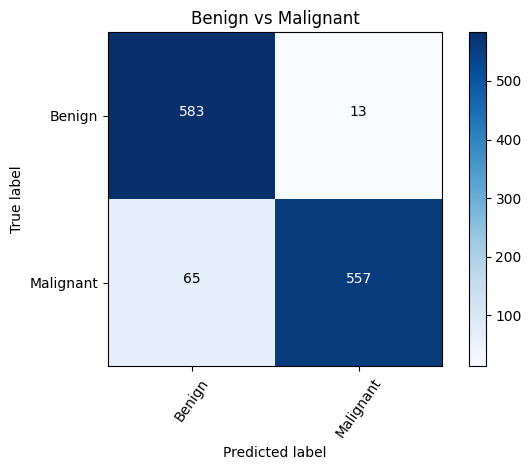

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Benign', 'Malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Benign vs Malignant')

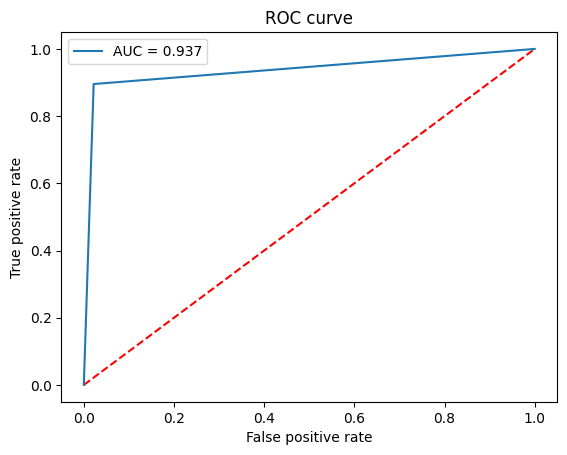

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

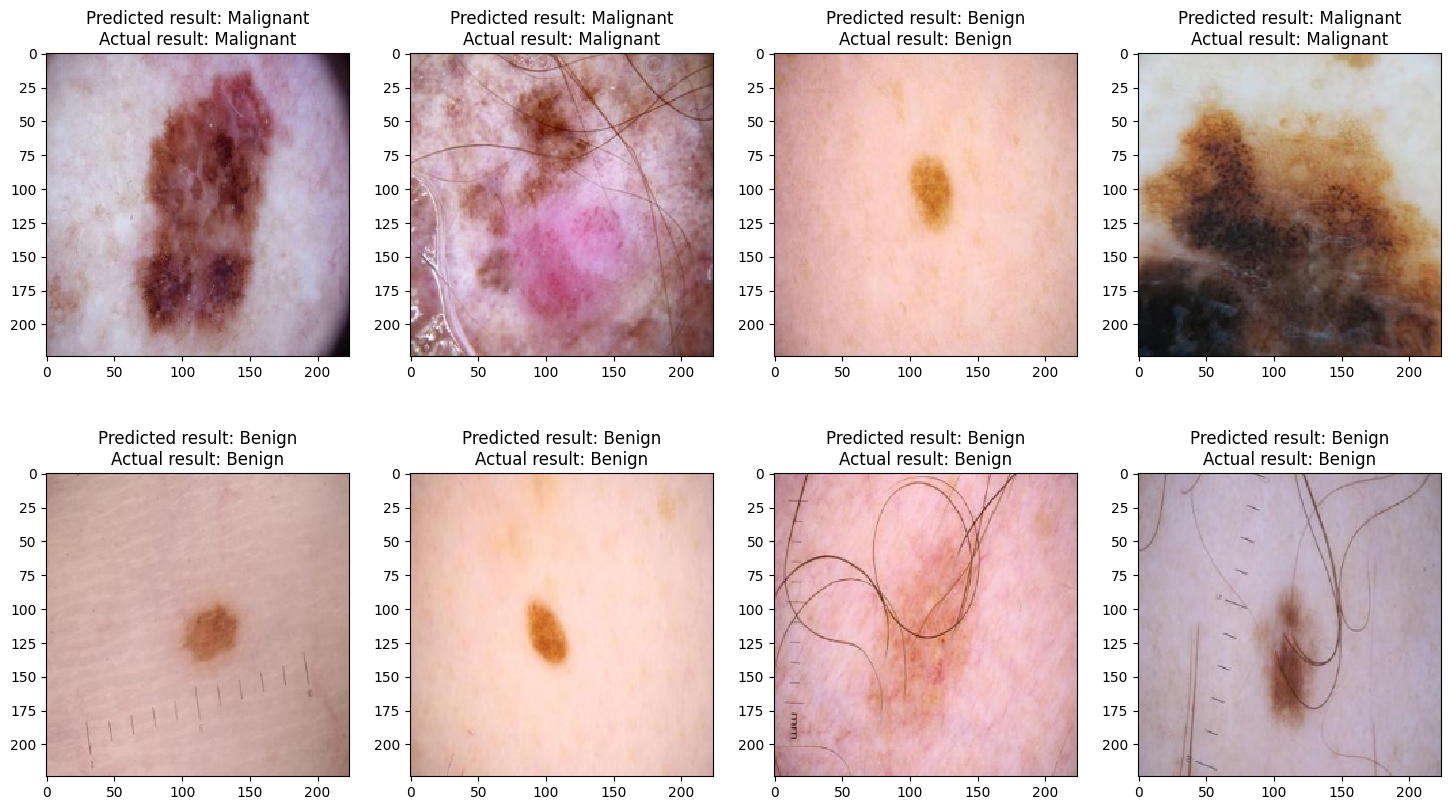

In [ ]:

i=0
prop_class=[]
mis_class=[]

for i in range(len(y_val)):
    if(np.argmax(y_val[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_val)):
    if(not np.argmax(y_val[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result: "+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_val[prop_class[i]])))
    plt.imshow(x_val[prop_class[i]], interpolation='nearest')
plt.show()

(0.0, 0.8)

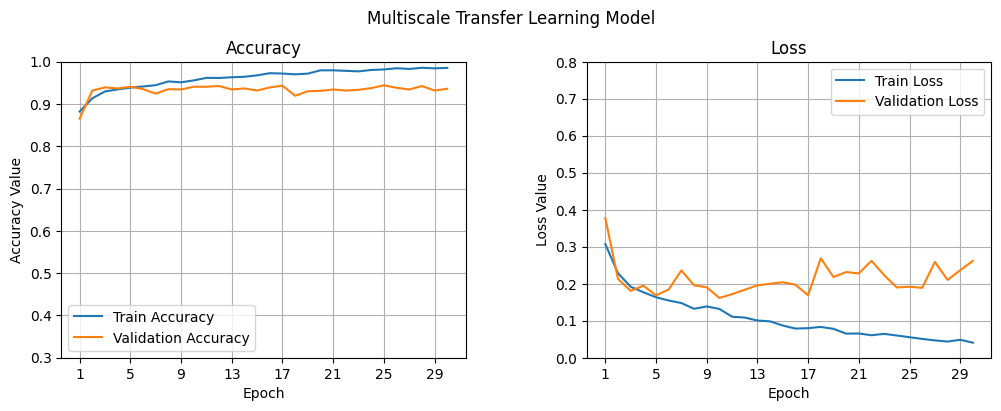

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 31, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax1.set_ylim(0.3, 1)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 31, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
ax2.set_ylim(0, 0.8)

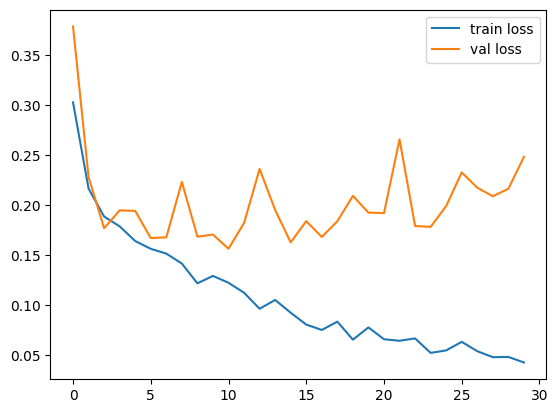

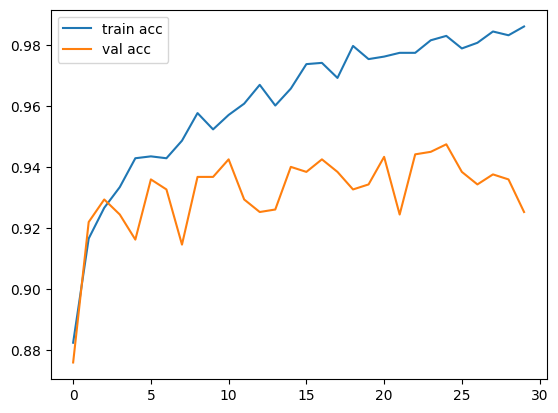

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

39/39 [==============================] - 5s 137ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Benign', 'Malignant']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Benign       0.89      0.98      0.93       616
   Malignant       0.97      0.87      0.92       602

    accuracy                           0.93      1218
   macro avg       0.93      0.92      0.92      1218
weighted avg       0.93      0.93      0.93      1218



In [ ]:
# def preprocess_input_image(image_path):
#     img = np.asarray(Image.open(image_path).convert("RGB"))
#     img = cv2.resize(img, (224, 224))
#     img = np.array(img)
#     return img

#input_image = np.array(preprocess_input_image('/content/drive/My Drive/research/skin_cancer/test/benign/1.jpg'))
# input_image = np.array(preprocess_input_image('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis/9062645R.png'))

# input_image_reshape = input_image.reshape(1, 224, 224, 3)

# pred=model.predict(input_image_reshape)
# input_pred = np.argmax(pred, 1)

# if input_pred[0] == 0:
#   plt.title('Not Melanoma')
# else:
#   plt.title('Melanoma')

# plt.imshow(input_image)
# plt.show()

In [ ]:
# from google.colab import files
# #Train and save your model
# model = model
# model.save('/content/drive/My Drive/research/skin_cancer/skin_cancer_xcep_94.h5')

# files.download('/content/drive/My Drive/research/skin_cancer/skin_cancer_inres_res_xcep.h5')